# Demo

Demo that was used in the course presentation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx

import random
from tqdm import trange
from typing import List

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rc('font', family='serif', serif="cmr10", size=18)
plt.rc('mathtext', fontset='cm', rm='serif')
plt.rc('axes', unicode_minus=False)

plt.rcParams['axes.formatter.use_mathtext'] = True

In [3]:
G = nx.karate_club_graph()

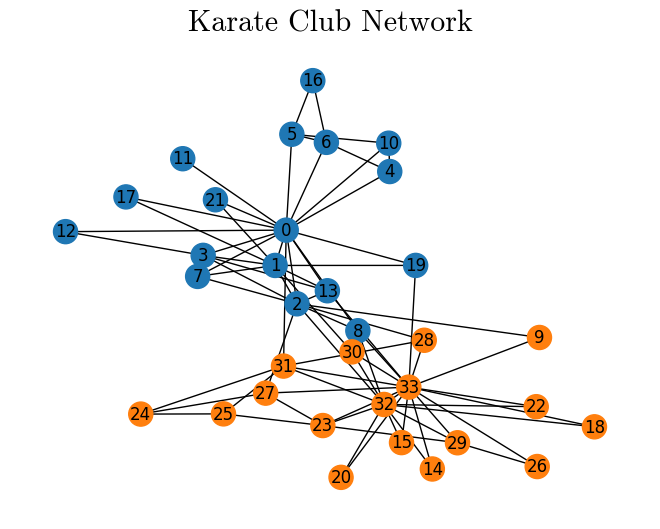

In [4]:
pos = nx.spring_layout(G, seed=0)
node_color = ['C0' if (G.nodes[u]['club'] == 'Mr. Hi') else 'C1' for u in G.nodes]
nx.draw(G, pos=pos, with_labels=True, node_color=node_color)
plt.title('Karate Club Network');

In [5]:
def random_walk(G: nx.Graph, u: int, steps: int, p: float, q: float) -> List[int] :
    v = random.choices(list(G.neighbors(u)))[0]
    path = [u, v]
    for _ in range(steps-1) :
        weights = {u: 1/p}
        # for all neighboring nodes in the current node `v`, except the previous node `u`
        for w in set(G.neighbors(v)) - {u} : 
            weights[w] = 1 if (w in set(G.neighbors(u))) else 1/q
        u = v
        # sample new node `v` according to the weights
        v = random.choices(list(weights.keys()), weights=weights.values())[0]
        path.append(v)
    return path

In [6]:
random_walk(G, 0, steps=10, p=1, q=1)

[0, 10, 4, 6, 16, 6, 5, 16, 5, 6, 4]

100%|██████████| 25/25 [00:04<00:00,  5.44it/s]


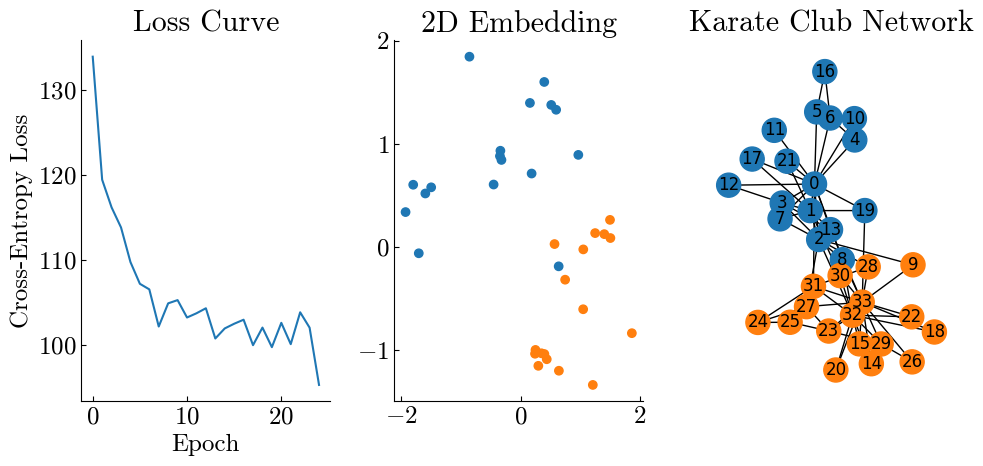

In [8]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(SkipGram, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        
    def forward(self, u: torch.Tensor, v: torch.Tensor):
        return (self.emb(u) * self.emb(v)).sum(dim=-1) # simply the dot product
    
n = G.number_of_nodes()
epochs = 25

model = SkipGram(len(G.nodes), 2)
optimizer = optim.SGD(model.parameters(), lr=0.3)

steps = 10 # number of steps 


total_loss = []
for _ in trange(epochs):
    # total_loss.append(0)
    loss = torch.tensor(0, dtype=torch.float32)
    optimizer.zero_grad()
    for node in np.random.permutation(n):

        # sample a random walk
        walk = random_walk(G, node, steps=steps, p=1, q=1)

        logits = torch.empty((steps+1, n), dtype=torch.float32)
        target = torch.zeros_like(logits)

        for (i, u) in enumerate(walk) :
            # for each in v in the context window, fill in probability
            for v in (walk[max(i-2, 0):i] + walk[i+1:i+3]) : 
                target[i,v] += 1/(min(steps,i+2) - max(i-2,0))
                
            # calculating the logits by doing dot products [forall v in V : phi_u*phi_v] (keeping u constant!)
            logits[i] = model(
                u*torch.ones(n, dtype=torch.long), 
                torch.arange(0, n)
            )

        loss += F.cross_entropy(logits, target)
    
    loss.backward()
    optimizer.step()
    total_loss.append(loss.item())


fig, ax = plt.subplots(1, 3, figsize=(10,5))
ax[0].plot(total_loss); ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Cross-Entropy Loss'); ax[0].set_title('Loss Curve')
ax[1].scatter(*model.emb.weight.detach().numpy().T, c=node_color); ax[1].set_title('2D Embedding')
nx.draw(G, pos=pos, with_labels=True, node_color=node_color, ax=ax[2]); ax[2].set_title('Karate Club Network')
fig.tight_layout()